# Regression Discontinuity

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Toy Example

In [187]:
tau = 10.
c = 0.
min_x = -50.
max_x = 50.
main_trend = lambda x: 50. - 1.*x + 0.02*x**2 + tau*(x>c)
y_scatter = lambda x: np.random.normal(0., 5.)
x_scatter = lambda x: np.random.uniform(-2., 2.)

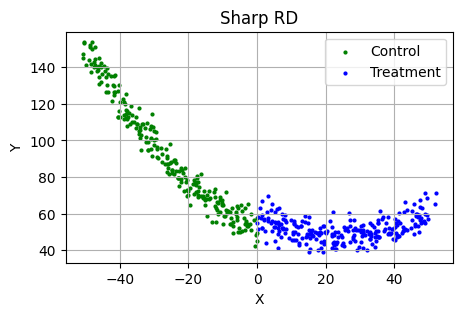

In [223]:
np.random.seed(42)
n_pts = 500
x_all = [x + x_scatter(x) for x in np.linspace(min_x, max_x, n_pts)]
x_0 = [x for x in x_all if x < c]
x_1 = [x for x in x_all if x >= c]
y_0 = [main_trend(x) + y_scatter(x) for x in x_0]
y_1 = [main_trend(x) + y_scatter(x) for x in x_1]

plt.figure(figsize=(5,3))
plt.scatter(x_0, y_0, s=4, c='green', label='Control')
plt.scatter(x_1, y_1, s=4, c='blue', label='Treatment')
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sharp RD")
plt.legend()
plt.show()

### Density 'Test'

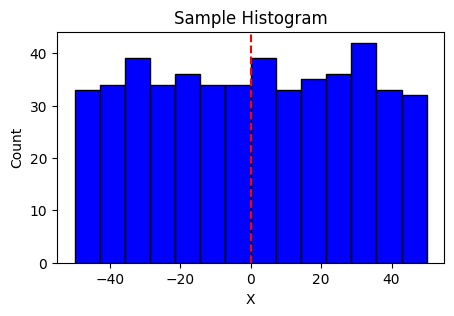

In [189]:
plt.figure(figsize=(5,3))
plt.hist(x_all, bins=np.linspace(min_x, max_x, 15), color="blue", edgecolor="black")
plt.axvline(x=c, color="r", linestyle="--")
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Sample Histogram")
plt.show()

### Bandwidth Definition

In [233]:
h_test = np.linspace(0.02*min(c-min_x, max_x-c), 0.5*min(c-min_x, max_x-c), 20)
x_0_local = [[x for x in x_0 if (c-x)<h] for h in h_test]
x_1_local = [[x for x in x_1 if (x-c)<h] for h in h_test]
y_0_local = [[y for (x,y) in zip(x_0,y_0) if (c-x)<h] for h in h_test]
y_1_local = [[y for (x,y) in zip(x_1,y_1) if (x-c)<h] for h in h_test]

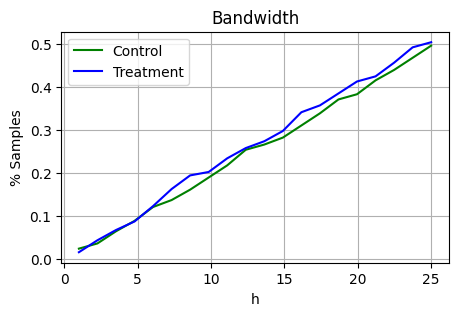

In [234]:
perc_0 = [len(x)/len(x_0) for x in x_0_local]
perc_1 = [len(x)/len(x_1) for x in x_1_local]

plt.figure(figsize=(5,3))
plt.plot(h_test, perc_0, c='green', label='Control')
plt.plot(h_test, perc_1, c='blue', label='Treatment')
plt.grid(True)
plt.xlabel("h")
plt.ylabel("% Samples")
plt.title("Bandwidth")
plt.legend()
plt.show()

### Local Non-Parametric Estimator

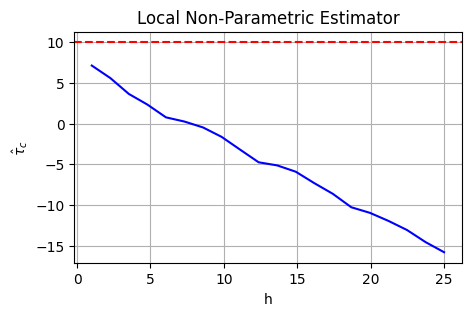

In [235]:
y_mean_hat_0 = [np.mean(y) for y in y_0_local]
y_mean_hat_1 = [np.mean(y) for y in y_1_local]
tau_hat = [y1-y0 for (y1,y0) in zip(y_mean_hat_1, y_mean_hat_0)]

plt.figure(figsize=(5,3))
plt.plot(h_test, tau_hat, c='blue')
plt.axhline(y=tau, color="r", linestyle="--")
plt.grid(True)
plt.xlabel("h")
plt.ylabel("$\\hat{\\tau}_c$")
plt.title("Local Non-Parametric Estimator")
plt.show()

### Local Linear Estimator

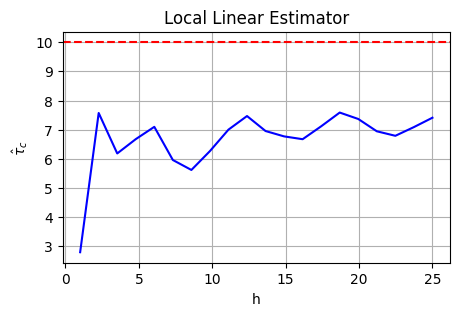

In [236]:
y_hat_0_model = [sm.OLS(y, sm.add_constant(x)) for (x,y) in zip(x_0_local, y_0_local)]
y_hat_0_fit = [model.fit() for model in y_hat_0_model]

y_hat_1_model = [sm.OLS(y, sm.add_constant(x)) for (x,y) in zip(x_1_local, y_1_local)]
y_hat_1_fit = [model.fit() for model in y_hat_1_model]

tau_hat = [(y_1.params[0]-y_0.params[0]) for (y_1,y_0) in zip(y_hat_1_fit, y_hat_0_fit)]

plt.figure(figsize=(5,3))
plt.plot(h_test, tau_hat, c='blue')
plt.axhline(y=tau, color="r", linestyle="--")
plt.grid(True)
plt.xlabel("h")
plt.ylabel("$\\hat{\\tau}_c$")
plt.title("Local Linear Estimator")
plt.show()

In [237]:
y_hat_0 = [y_0_fit.predict(sm.add_constant(x_0)) for (y_0_fit, x_0) in zip(y_hat_0_fit, x_0_local)]
y_hat_1 = [y_1_fit.predict(sm.add_constant(x_1)) for (y_1_fit, x_1) in zip(y_hat_1_fit, x_1_local)]

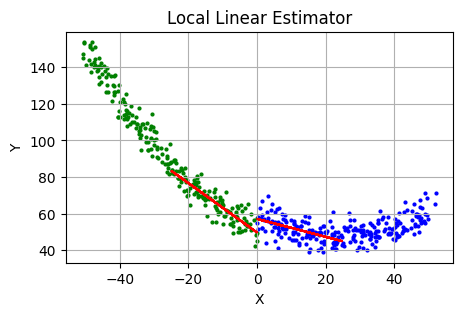

In [241]:
i_ = -1
plt.figure(figsize=(5,3))
plt.scatter(x_0, y_0, s=4, c='green', label='Data')
plt.plot(x_0_local[i_], y_hat_0[i_], c='red', label='Regression')

plt.scatter(x_1, y_1, s=4, c='blue', label='Data')
plt.plot(x_1_local[i_], y_hat_1[i_], c='red', label='Regression')
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Local Linear Estimator")
plt.show()

### Variance Estimator

In [254]:
e2_1 = [[(y-y_hat)**2 for (y, y_hat) in zip(y, y_hat)] for (y, y_hat) in zip(y_1_local, y_hat_1)]
e2_0 = [[(y-y_hat)**2 for (y, y_hat) in zip(y, y_hat)] for (y, y_hat) in zip(y_0_local, y_hat_0)]

In [255]:
sigma2_hat_1 = [1/len(x_1_local) * np.sum(e2) for e2 in e2_1]
sigma2_hat_0 = [1/len(x_0_local) * np.sum(e2) for e2 in e2_0]